`06_ensemble.ipynb`

# Ensemble 🧩🌈🎨

- 정형 데이터(Structured Data) 기준으로는 가장 뛰어난 성과를 내는 알고리즘 -> 앙상블 학습
- 대부분의 앙상블 학습 -> 트리 기반

## Random Forest
- 결정트리를 랜덤하게 만들어 트리의 숲을 만듦
- 각 결정트리의 예측을 종합해 최종 예측을 만듦
- 과대적합(overfitting)에 안전 !

### 데이터 분할
- 데이터가 1000개면, 각 트리마다 1000개 데이터를 복원 추출함. 이때 중복을 허용 (우연히 같은 데이터만 1000개 가능)
- 노드를 분할 시, 분류 / 회귀의 특성 선택 방식이 다름(분류: 개수를 루트함, 회귀: 특성을 다 씀)
- 기본값 100개의 트리를 만들어서 
    - 분류 : 다수결 투표
    - 회귀 : 100개의 평균

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

wine = pd.read_csv('./wine.csv')
X = wine[['alcohol', 'sugar', 'pH']]
y = wine['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [2]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1, random_state=42)

scores = cross_validate(rf, X_train, y_train, return_train_score=True, n_jobs=-1)

# 결정트리가 max_depth 튜닝이 없으면 Overfitting 됨
#           훈련셋(일부)                      검증셋(훈련셋의 일부)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

# 진짜 학습 시키기
rf.fit(X_train, y_train)

'''
이전 단일트리 특성 중요도: [0.12345626 0.86862934 0.0079144]
랜덤 포레스트 특성 중요도: [0.23167441 0.50039841 0.26792718]

노드마다 랜덤하게 특성들을 뽑아서 사용 -> 다양한 특성들이 훈련에서 기준으로 쓰임
-> 특정 특성에 과도하게 집중 방지 -> 다양한 특성이 훈련에 쓰일 기회를 받음 -> Overfitting을 줄이고 일반화 성능 높임
'''

# 트리(100개)들의 특성별 중요도 수치화
print(rf.feature_importances_)

0.9973541965122431 0.8905151032797809
[0.23167441 0.50039841 0.26792718]


In [3]:
# OOB(Out Of Bag) 샘플 -> 쓰지않을 샘플 존재 -> 남은 데이터들을 모아서 만든 샘플 (훈련에 참여 안 한 샘플)
# OOB 샘플로 점수 -> 마치 검증샘플 같은 역할
rf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train), rf.oob_score_)

0.996921300750433 0.8934000384837406


In [4]:
# 랜덤 포레스트의 하이퍼 파라미터 튜닝

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


params = {
    # Decision Tree 의 HP
    'max_depth': randint(3, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    # Random Forest 의 HP
    'max_features': ['sqrt', 'log2', None],  # 노드별 분할시 고려할 특성 수 (None->모든 특성 고려)
    'n_estimators': randint(50, 300)  # 트리 개수
}

rs = RandomizedSearchCV(
    rf,
    params,
    n_iter=100,
    n_jobs=-1,
    random_state=42
)

rs.fit(X_train, y_train)

,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'max_depth': <scipy.stats....0027C1666ABA0>, 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': <scipy.stats....0027C1671E850>, 'min_samples_split': <scipy.stats....0027C1671D1D0>, ...}"
,n_iter,100
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [5]:
print('최적 파라미터', rs.best_params_)
print('최고 교차검증 점수', rs.best_score_)
print('테스트 스코어', rs.score(X_test, y_test))
# 최적 모델 인스턴스
best_rf = rs.best_estimator_
print('특성 중요도', best_rf.feature_importances_)

최적 파라미터 {'max_depth': 14, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 217}
최고 교차검증 점수 0.8878202043384912
테스트 스코어 0.8807692307692307
특성 중요도 [0.22248576 0.53167438 0.24583986]


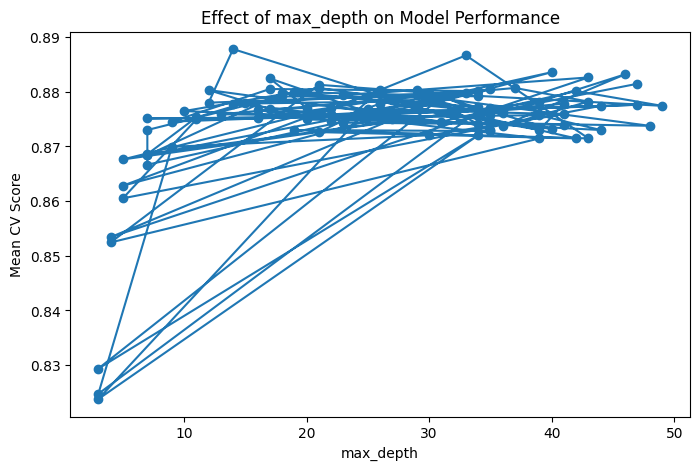

In [6]:
import matplotlib.pyplot as plt

results = pd.DataFrame(rs.cv_results_)

# max_depth vs mean_test_score
plt.figure(figsize=(8, 5))
plt.plot(results['param_max_depth'], results['mean_test_score'], marker='o')
plt.xlabel("max_depth")
plt.ylabel("Mean CV Score")
plt.title("Effect of max_depth on Model Performance")
plt.show()

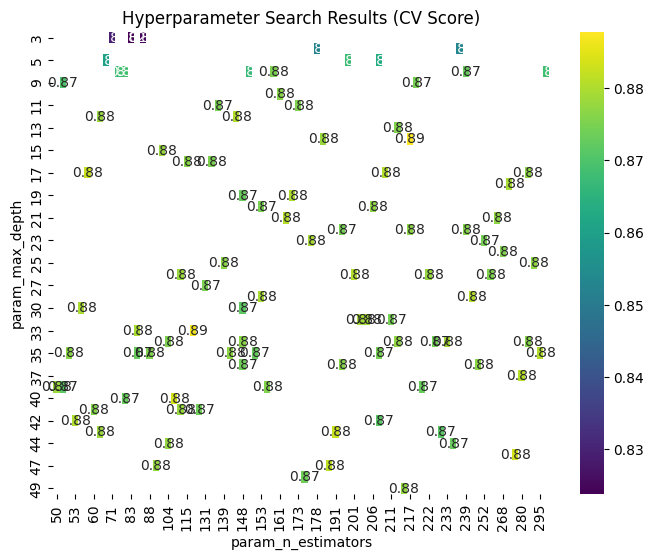

In [7]:
import seaborn as sns

pivot_table = results.pivot_table(values='mean_test_score',
                                  index='param_max_depth',
                                  columns='param_n_estimators')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.title("Hyperparameter Search Results (CV Score)")
plt.show()

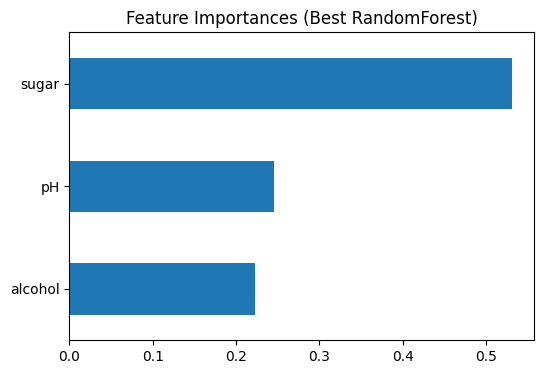

In [8]:
best_rf = rs.best_estimator_
importances = pd.Series(best_rf.feature_importances_, index=X.columns)

plt.figure(figsize=(6,4))
importances.sort_values().plot(kind='barh')
plt.title("Feature Importances (Best RandomForest)")
plt.show()

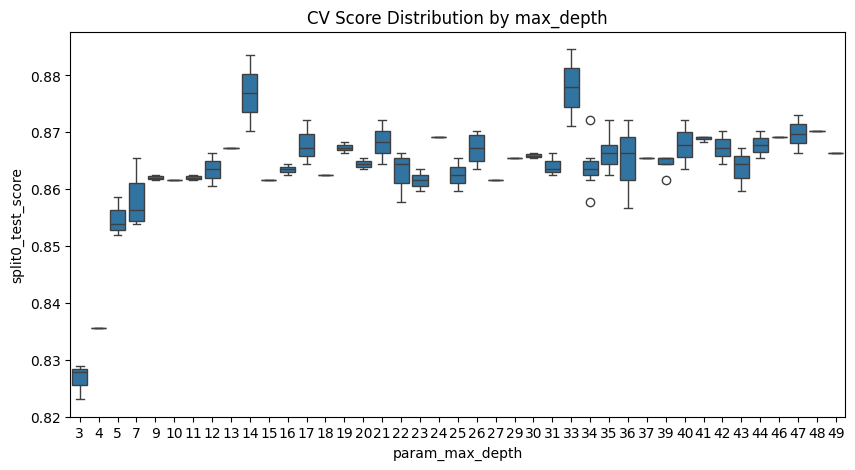

In [9]:
# 교차검증 결과 분포
plt.figure(figsize=(10,5))
sns.boxplot(x='param_max_depth', y='split0_test_score', data=results)
plt.title("CV Score Distribution by max_depth")
plt.show()

## Extra Tree
- 랜덤 포레스트와 매우 유사
- 부트스트랩 샘플(복원추출)을 사용하지 않음
- 전체 훈련세트 그대로 사용함. 특성도 무작위 선택
- 노드 분할할 때, 최적(불순도/정보이득)을 찾는 것이 아니라 무작위로 분할
- 성능이 낮아질 수 있지만, 많은 트리를 앙상블 해서 과대적합을 방지
- 데이터 노이즈가 많은 경우 장점 (패턴과 상관없는 불필요/잘못된 데이터)

In [10]:
from sklearn.ensemble import ExtraTreesClassifier

# 모델에서 CPU 최대 활용
et = ExtraTreesClassifier(n_jobs=-1, random_state=42)

# 모델 교차검증 CPU 최대 활용
scores = cross_validate(et, X_train, y_train, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

et.fit(X_train, y_train)

print(et.score(X_test, y_test), et.feature_importances_)

0.9974503966084433 0.8887848893166506
0.8861538461538462 [0.20183568 0.52242907 0.27573525]


## 그래디언트 부스팅 (Gradient Boosting)

- 부스팅: 약한 모델(결정트리가 얕다)을 여러 개 차례대로 학습.
- 앞에 모델에서 틀린 부분을 뒤의 모델이 보완해주는 방식
- 그래디언트: 오차를 줄이기 위해 경사하강법 아이디어를 적용

## 장점

- 비선형, 복잡한 데이터에서 예측이 뛰어남
- 과적합 방지 가능한 여러 규제들이 있음
- 별도 전용 라이브러리(XGBoost, LightGBM, CatBoost) -> 대회에서 1등 먹은 적이 많음

## 단점

- 학습 속도 느림 (순차학습 -> 병렬화 불가능)
- 하이퍼파라미터가 많아서 튜닝이 필요
- 데이터 노이즈에 민감한 편

1. 약한 첫 번째 결정트리 학습 -> 기본 예측값 생성
2. 오차(residual) 계산 (답 - 예측)
3. 이 잔차를 예측하도록 또 다른 작은 트리를 학습 -> 예측값 업데이트
4. 반복 -> 오차가 줄어듦

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

hgb = GradientBoostingClassifier(random_state=42)
scores = cross_validate(hgb, X_train, y_train, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

# 학습 -> 테스트 셋 점수
hgb.fit(X_train, y_train)
print(hgb.score(X_test, y_test))

0.8881086892152563 0.8720430147331015
0.8669230769230769


## 히스토그램 기반 그래디언트 부스팅
- 입력 특성들을 256개 구간으로 나눔
- 노드 분할 할때, 구간 경계값(256개)을 쓰기에 최적분할을 가장 빠르게 찾을 수 있다
**Hist Gradient Boosting 은 결측치를 자동으로 채워주는 기능이 있다**

### 1. 직접 결측치 채우기 (Imputation)
방법: 평균/중앙값 대체, KNN imputation, MICE 등

✅ 장점
- 모델에 독립적: 어떤 모델이든(트리, 선형, 신경망) 학습할 수 있게 됨
- 도메인 지식 반영 가능: 예를 들어 나이가 결측이면 "20대 평균값"으로 채우는 식으로 의미 있게 대체 가능
- 노이즈 제어 가능: 결측치가 너무 많을 때 모델이 이상하게 학습하지 않도록 사전에 통제 가능
⚠️ 단점
- 잘못된 방법으로 채우면 편향이 생길 수 있음 (예: 평균 대체 → 분산 축소, 패턴 왜곡)
- 고차원 데이터에서 계산량이 크거나 불안정할 수 있음 (특히 MICE, KNN)
---
### 2. HistGradientBoosting에 맡기기 (자동 결측 처리)
✅ 장점
- 추가 전처리 불필요: NaN 그대로 넣으면 학습 가능 → 파이프라인 단순화
- 모델이 결측 그 자체를 패턴으로 활용 가능 (예: “나이 없음” 자체가 중요한 특징일 때 유용)
빠르고 효율적 (히스토그램 기반 트리라 속도도 빠름)
⚠️ 단점
- 다른 모델에 적용 불가 (결측치 처리 기능이 없는 모델과 비교 불가)
- 결측치가 너무 많으면, 모델이 “NaN 브랜치”에 데이터를 몰아넣어서 과적합 위험 있음
- 도메인 지식을 반영하기 어려움 (모델이 무작정 NaN을 또 하나의 값으로 취급)

In [13]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(random_state=42)
scores = cross_validate(hgb, X_train, y_train, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

# 학습 -> 테스트 셋 점수
hgb.fit(X_train, y_train)
print(hgb.score(X_test, y_test))

0.9321723946453317 0.8801241948619236
0.8723076923076923


In [ ]:
%pip install xgboost lightgbm

In [19]:
from xgboost import XGBClassifier

xgb = XGBClassifier(tree_method='hist', random_state=42)

scores = cross_validate(xgb, X_train, y_train, return_train_score=True)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

xgb.fit(X_train, y_train)
print(xgb.score(X_test, y_test))

0.9567059184812372 0.8783915747390243
0.8746153846153846


In [22]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=42)

scores = cross_validate(lgb, X_train, y_train, return_train_score=True)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

lgb.fit(X_train, y_train)
print(lgb.score(X_test, y_test))

[LightGBM] [Info] Number of positive: 3151, number of negative: 1006
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 372
[LightGBM] [Info] Number of data points in the train set: 4157, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.757999 -> initscore=1.141738
[LightGBM] [Info] Start training from score 1.141738
[LightGBM] [Info] Number of positive: 3151, number of negative: 1006
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 4157, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.757999 -> initscore=1.141738
[LightGBM] [Inf